### Instituto Superior de Engenharia de Lisboa

## Classificação e Autenticação Biométrica com sinais de Fotopletismografia (PPG)

#### Data de Entrega: 6 de novembro de 2024

### Alunos:
- Ana Sofia Oliveira (39275)
- Eduardo Santos (40610)

____________________
## Tabela de Conteúdos

- [Introducao](#introducao)
- [Configurações Iniciais](#configurações-iniciais)
   * [Imports](#imports)
   * [Funções Auxiliares](#funções-auxiliares)
- [Dataset](#dataset)
- [Pré-processamento](#pre-processamento)
   * [Filtragem](#filtragem)
   * [Segmentação](#segmentacao)
   * [Outlier Detection](#outlier-detection)
- [Feature Extraction](#feature-extraction)
   * [Template Selection](#template-selection)
- [Domínio do Problema](#domínio-do-problema)
- [Problema Multiclasse](#problema-multiclasse)
   * [Modelo](#modelo)
   * [Treino](#treino)
   * [Teste](#teste)
   * [Avaliação](#avaliação)
- [Problema Binário](#problema-binário)
   * [Modelo](#modelo-1)
   * [Treino](#treino-1)
   * [Teste](#teste-1)
   * [Avaliação](#avaliação-1)
- [Conclusão](#conclusão)
- [Referências](#referências)

___________________
<a name='introducao'></a>
## Introdução

O presente trabalho tem como objetivo a classificação e autenticação biométrica com sinais de fotopletismografia (PPG). A fotopletismografia é uma técnica que permite medir a variação do volume de sangue em função do tempo, através da deteção de variações de luz transmitida ou refletida por um tecido. Este tipo de sinal é usualmente utilizado em dispositivos _wearables_, como _smartwatches_, para medir a frequência cardíaca.

No decorrer deste documento serão exploradas várias técnicas de processamento de sinal e aprendizagem automática para a classificação e autenticação biométrica dos indivíduos.

O documento encontra-se organizado da seguinte forma:
- Leitura e pré-processamento do dataset;
- Filtragem e segmentação dos sinais;
- Detecção de _outliers_;
- Seleção de _templates_;
- Classificação e autenticação biométrica.

No bloco de leitura e pré-processamento do dataset, os sinais serão obtidos a partir do dataset "BIDMC PPG and Respiration Dataset", onde as classes corresponderão ao identificativo de cada indivíduo. O dataset fornecido contém sinais PPG de 53 indivíduos, com uma taxa de amostragem de 125 Hz. Cada sinal é composto por 8 minutos de gravação.

De seguida, é aplicada uma filtragem para remover o ruído dos sinais obtidos e segmentar os mesmos em janelas temporais (templates) de 600ms. 

A deteção de _outliers_ permitirá reduzir a variabilidade dos sinais, removendo os sinais que se afastam significativamente da média. Assim, será possível eliminar os _templates_ que não representam corretamente o indivíduo.

A seleção de _templates_ é uma etapa crucial para a classificação e autenticação biométrica. Neste caso, serão selecionados os _templates_ que melhor representam cada indivíduo, de forma a minimizar a variabilidade dos sinais.

Por fim, a classificação e autenticação biométrica será realizada em dois problemas distintos: um problema multiclasse, onde as classes correspondem aos identificativos dos indivíduos, e um problema binário, onde as classes correspondem à autenticação de um indivíduo.

_____________
<a name="configurações-iniciais"></a>

## Configurações Iniciais
Nesta secção são definidas as dependências funcionais e estruturais do projeto. O projeto proposto depende funcionalmente da utilização das bibliotecas importadas na sub-secção Imports, e estruturalmente das funções auxiliares criadas durante o seu desenvolvimento. 

<a name="imports"></a>

### Imports

In [150]:
import os
import wfdb
import pickle
import numpy as np
import random as rd
import matplotlib.pyplot as plt

from biosppy.signals import ppg as bppg
from biosppy.clustering import outliers_dbscan

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.utils import plot_model

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

<a name="funções-auxiliares"></a>

### Funções Auxiliares

In [151]:
def plotOutlierDetectionDetails(ind_id, templates, valid, outliers): 
    axis = np.linspace(0, 600, 75)

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Indivíduo {ind_id}")
    plt.subplot(221)
    plt.title(f"{len(templates)} Templates")
    plt.plot(axis, templates.T);
    
    plt.subplot(222)
    plt.title(f"Oultier Detection com DBSCAN")
    plt.plot(axis, valid.T, label='Templates Válidos', color='black');
    plt.plot(axis, outliers.T, label='Outliers', color='red', alpha=0.2);

    plt.subplot(223)
    plt.title(f"{len(valid)} Templates Válidos")
    plt.plot(axis, valid.T, label='Templates Válidos', color='black');

    plt.subplot(224)
    plt.title(f"{len(outliers)} Outliers")
    plt.plot(axis, outliers.T, label='Outliers', color='red');

    plt.tight_layout()
    plt.show()
    
    os.makedirs(f"imgs/ind{ind_id}", exist_ok=True)
    plt.savefig(f"imgs/ind{ind_id}/outlier_detection.png")


def plotSignalDetails(data, nSegundos=10): 
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Indivíduo " + str(data['subject']))

    plt.subplot(321)
    plt.title(f"Raw Vs Filtrado")
    plt.plot(data['signal']);
    plt.plot(data['f_signal']);
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend(["raw", "filtrado"])

    plt.subplot(322)
    plt.title(f" Raw Vs Filtrado ({nSegundos} segundos)")
    plt.plot(data['signal'][:nSegundos*data['fs']]);
    plt.plot(data['f_signal'][:nSegundos*data['fs']]);
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend(["raw", "filtrado"])

    plt.subplot(323)
    plt.title(f"Raw templates")
    plt.plot(data['old_templates'].T);
    
    plt.subplot(324)
    plt.title(f"Templates")
    plt.plot(data['templates'].T);

    plt.subplot(325)
    plt.title(f"Templates Válidos")
    plt.plot(data['templates'].T, color='green');

    plt.subplot(326)
    plt.title(f"Outliers")
    plt.plot(data['outliers'].T, color='red');
    
    plt.tight_layout()
    plt.show()

    os.makedirs(f"imgs/ind{data['subject']}", exist_ok=True)
    plt.savefig(f"imgs/ind{data['subject']}/signal.png")


def plotTemplatesHistogram(data, key='templates', limite=None):
    nTemplates = [len(templates) for templates in [individuo[key] for individuo in data]]
    print(f"Mínimo de templates: {np.min(nTemplates)} (indivíduo {data[np.argmin(nTemplates)]['subject']})")
    print(f"Máximo de templates: {np.max(nTemplates)} (indivíduo {data[np.argmax(nTemplates)]['subject']})")
    
    print("Limite: ", limite)
    if limite is not None: 
        min = limite
        max = limite
        mean = limite
    else:
        min = int(np.min(nTemplates))
        max = int(np.max(nTemplates))
        mean = int(np.mean(nTemplates))

    plt.figure(figsize=(12, 6))
    plt.bar([individuo['subject'] for individuo in data], nTemplates);
    plt.axhline(y=min, color='r', linestyle='-.');
    plt.axhline(y=max, color='g', linestyle='-.');
    plt.axhline(y=mean, color='orange', linestyle='-.');
    plt.title('Distribuição de templates por indivíduo')
    plt.xlabel('Indivíduo')
    plt.ylabel('Número de Templates')
    plt.legend([f"Mínimo={min}", f"Máximo={max}", f"Média={mean}", "Número de templates"])
    plt.tight_layout()
    plt.show()
    
    os.makedirs(f"imgs/ind{individuo['subject']}", exist_ok=True)
    plt.savefig(f"imgs/ind{individuo['subject']}/templates_histogram.png")

    return min, max, mean


def plotModelHistory(history, type='multi'):
    # Extract metrics from the history object
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    # Number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training loss');
    plt.plot(epochs, val_loss, 'b', label='Validation loss');
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training accuracy');
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy');
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    os.makedirs(f"imgs", exist_ok=True)
    plt.savefig(f"imgs/{type}_model.png")


def plotConfusionMatrix(true_classes, pred_classes, type='multi'): 
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_classes, pred_classes)
    matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(true_classes))
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('Matriz de confusão do teste', fontsize=20)
    matrix.plot(ax=ax, cmap='viridis');
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    os.makedirs(f"imgs", exist_ok=True)
    plt.savefig(f"imgs/{type}_confusionMatrix.png")


def plotROCCurves(true_classes, pred_classes): 
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(true_classes, pred_classes)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})');
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    os.makedirs(f"imgs", exist_ok=True)
    plt.savefig(f"imgs/rocCurve.png")

______________
<a name="dataset"></a>
## Dataset

O dataset utilizado foi o "BIDMC PPG and Respiration Dataset", na sua primeira versão, da Physionet. 

Este dataset contém sinais e dados numéricos de formas de onda MIMIC II, extraídos do banco de dados, juntamente com as anotações manuais das respirações, realizadas por dois anotadores, utilizando os sinais respiratórios de impedância. 

Os dados foram adquiridos a partir de pacientes hospitalizados em estado crítico no centro médico Beth Israel Deaconess (Boston, MA, EUA), durante o seu atendimento hospitalar, tendo o registo das respirações sido realizado manualmente por dois anotadores, a partir de cada gravação, usando o sinal respiratório de impedância. Cada gravação, com duração de 8 minutos, contém os seguintes dados: 
- Sinais fisiológicos, como PPG, sinal respiratório de impedância e eletrocardiograma (ECG). Estes sinais são amostrados a 125 Hz.
- Parametros fisiológicos, como frequência cardíaca (HR), frequência respiratória (RR) e nível de saturação de oxigênio no sangue (SpO2). Estes são amostrados a 1 Hz. 
- Parametros fixos, como a idade e o género. 
- Anotações manuais da respiração. 

Este dataset disponiliza todos estes dados em formato WFDB (WaveForm DataBase), formato padrão utilizado pela PhysioNet. Sendo que, para cada gravação existem 5 arquivos (onde ## representa o número do sujeito): 
- bidmc##.breath: Anotações manuais de respiração.
- bidmc##.dat: Arquivo de dados de forma de onda.
- bidmc##.hea: Arquivo de cabeçalho de forma de onda.
- bidmc##n.dat: Arquivo de dados numéricos.
- bidmc##n.hea: Arquivo de cabeçalho numérico.

No contexto deste projeto utilizaremos apenas as gravações relativas aos sinais de PPG em forma de onda, ou seja, os registos disponibilizados no ficheiros arquivos bidmc##.dat. 

O dataset foi descarregado e armazenado localmente, tendo sido recolhidas as informações apresentadas no dicionário abaixo: 

```python
data = [
            {
            'subject': id do sujeito (indivíduo), 
            'signal': sinal PPG, 
            'fs': frequência de amostragem do sinal
            }, 
            ...
        ]
```

In [152]:
def load_dataset(records_folder): 
    with open(f'{records_folder}bidmc-ppg-and-respiration-dataset-1.0.0\RECORDS', 'r') as file:
        records = file.readlines()
        records = [record.strip() for record in records]

    data = []

    for record in records:
        record_name = f"{records_folder}bidmc-ppg-and-respiration-dataset-1.0.0/{record}"
        print("Record name:", record_name)
        try:
            record, fields = wfdb.rdsamp(record_name)

            if ('PLETH,' in fields['sig_name']):
                ppg = record[:,fields['sig_name'].index('PLETH,')]
                fs = fields['fs']
                data.append({'subject': int(record_name[-2:]), 
                                'signal': ppg,
                                'fs': fs})
                print("-> Adicionado sinal do individuo", record_name)
        except Exception as e:
            print("Erro ao adicionar sinal do individuo", record_name, e)

    return data

In [153]:
# records_folder = "../spikes/ppg/"
records_folder = "../ppg/dataset/"

data = load_dataset(records_folder)

Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc01
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc01
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc02
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc02
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc03
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc03
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc04
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc04
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc05
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc05
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc06
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-re

O bloco de código abaixo verifica os dados obtidos após o processo de leitura. 

Podemos verificar que foram lidos dados de 53 indivíduos, com 60000 amostras por sinal ($ \frac{\frac{6000}{125}}{60} = 8 $ minutos ). 

Adicionalmente, são apresentados os sinais dos três primeiros indivíduos. Podemos verificar, a partir dos gráficos que apresentam 5 segundos de sinal, que existem diferenças estruturais entre os sinais dos diferentes individuos. São estas alterações permitirão discriminar os diferentes utilizadores a partir dos seus sinais fisiológicos.  

Número de indivíduos: 51
Frequência de amostragem: 125
Duração dos sinais: 480.008 segundos, 8.000 minutos


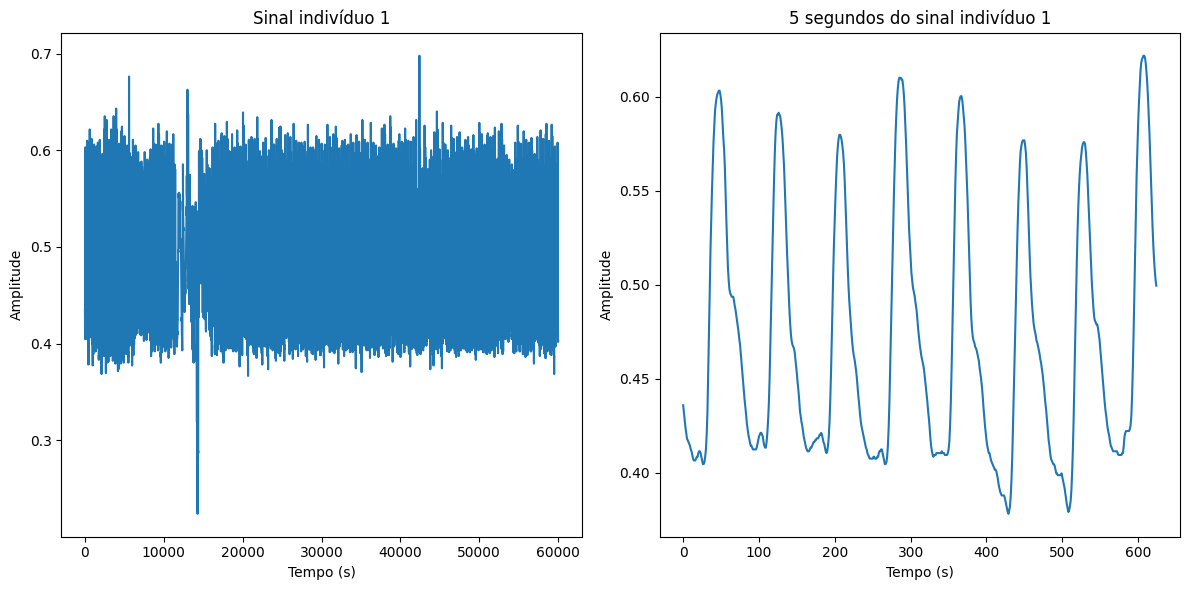

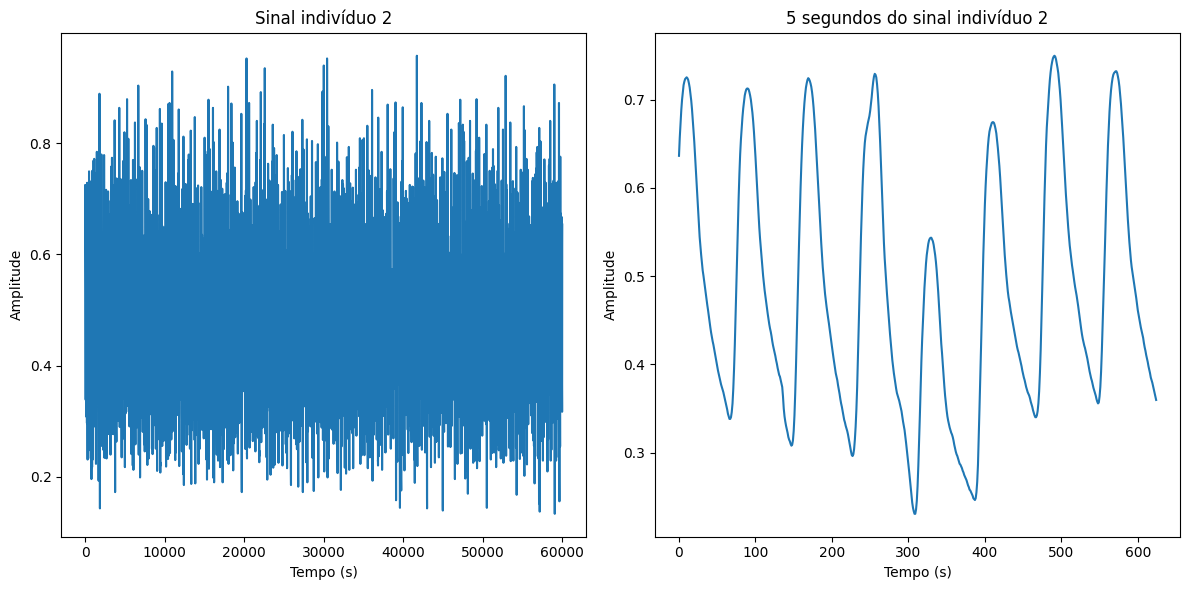

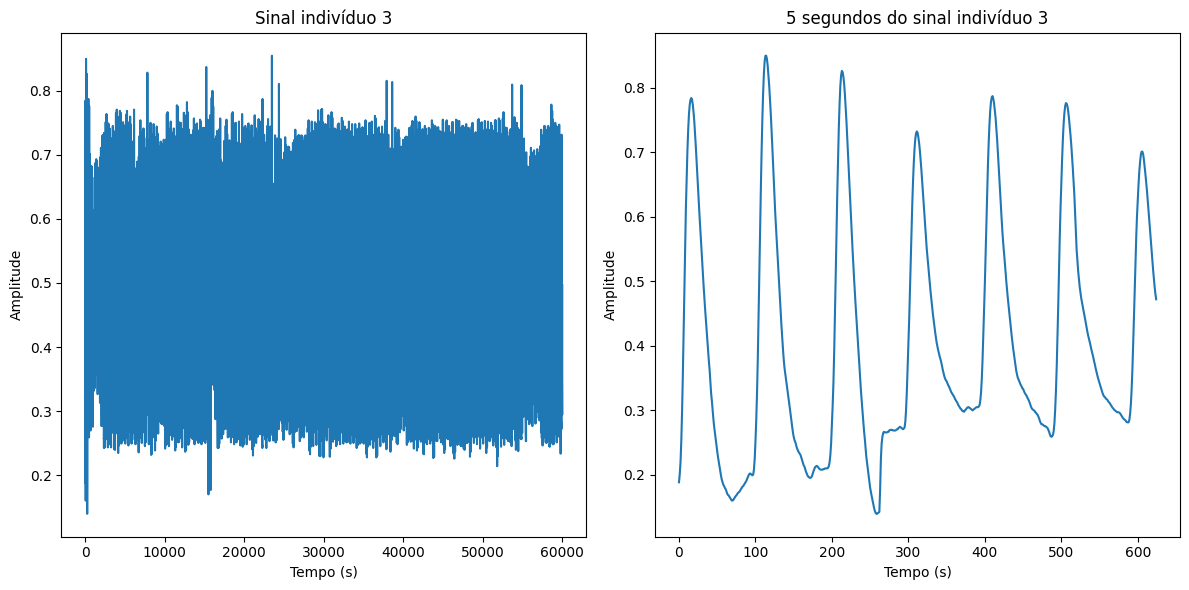

In [154]:
print("Número de indivíduos:", len(data))
print("Frequência de amostragem:", data[0]['fs'])
print(f"Duração dos sinais: {len(data[0]['signal'])/data[0]['fs']:.3f} segundos, {len(data[0]['signal'])/(data[0]['fs']*60):.3f} minutos")

nIndividuos = 3
nSegundos = 5

for nIndividuo in range(nIndividuos):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title(f"Sinal indivíduo {data[nIndividuo]['subject']}")
    plt.plot(data[nIndividuo]['signal'])
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')

    plt.subplot(122)
    plt.title(f"{nSegundos} segundos do sinal indivíduo {data[nIndividuo]['subject']}")
    plt.plot(data[nIndividuo]['signal'][:nSegundos*data[nIndividuo]['fs']])
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')    
    plt.tight_layout()
    plt.show();

_____________
<a name="pre-processamento"></a>
## Pré-processamento

A aquisição do sinal é feita através de um sensor ótico, que recolhe informação da variação da quantidade de sangue nos vasos sanguíneos, em função do tempo. Este sensor emite uma luz, que é refletida pelos vasos sanguíneos, e recolhe a informação da quantidade de luz refletida. Por este motivo, a aquisição do sinal é sensível a diferentes fatores, como a pressão do sensor, a posição do sensor, a temperatura, a luz ambiente, entre outros, provocando distorções no sinal.

O pré-processamento do sinal é essencial para garantir que os dados utilizados no modelo têm a melhor qualidade e consistência possíveis. Processos como os de normalização, filtragem, segmentação e remoção de outliers são essenciais para garantir que o sistema opere sobre dados com informações limpas e bem definidas.

Nesta secção, focaremos os processos de filtragem e segmentação do sinal, bem como a remoção de outliers. A filtragem permite remoção de ruídos que distorcem o sinal. A segmentação permite dividir o sinal em janelas de interesse. 

### Filtragem <a name="filtragem"></a>

A filtragem é um processo essencial na remoção de ruído do sinal. O sinal de PPG é um sinal de baixa frequência. Por isso, é importante remover ruídos de alta frequência, como, por exemplo, o ruído de 50Hz provocado por interferências elétricas. 

A função abaixo permite aplicar um filtro passa-banda no sinal entre 1 e 8Hz, de forma a remover ruído de alta frequência. Para isto, recorremos à biblioteca BioSpy, que disponibiliza funções para processamento de sinais, como o PPG. Para além do sinal filtrado, a função retorna também os indices dos picos do sinal, que serão, posteriormente, utilizados na segmentação do sinal. 

In [155]:
def filtragem(sinal, fs, show=False): 
    return bppg.ppg(signal=signal, sampling_rate=fs, show=show)

### Segmentação <a name="segmentacao"></a>

A segmentação do sinal consiste na divisão do sinal em janelas (templates), de forma a manter apenas os dados de interesse. O sinal de PPG é um sinal periódico, pelo que cada ciclo corresponde a um template. Assim, a segmentação do sinal permite manter apenas os templates do sinal, eliminando a excedente informação. 

Conforme mencionado anteriormente, os picos do sinal foram identificados durante o processo de filtragem, correspondendo ao maior pico identificado de cada ciclo. Assim, foi definida uma janela de segmentação de 600ms, centrada no pico do sinal. Isto é, por cada pico identificado, são mantidos 200ms antes e 400ms após o pico de cada ciclo.

A função abaixo permite segmentar o sinal, em função do sinal e dos picos identificados. Para isso, a função recebe o sinal filtrado e os respetivos indices dos picos, e retorna os templates do sinal.

In [156]:
def segmentation(sinal, picos, fs):

    offset_left = int(200*fs/1000)
    offset_right = int(400*fs/1000)

    templates = np.array([sinal[pico-offset_left:pico+offset_right] for pico in picos[:-1]])

    return templates

<a name="outlier-detection"></a>

### Outlier Detection

O processo de outlier detection permite identificar templates que se encontram fora da distribuição normal do sinal. Estes templates podem ser causados por ruídos, que não foram filtrados durante os processos anteriores, ou por variações anómalas do sinal. Com a presença de outliers pode distorcer o modelo, levando a previsões incorretas, este processo é essencial para identificar estes templates e removê-los.

O algoritmo de deteção de outliers utilizado foi o DBSCAN (Density-Based Spatial Clustering of Applications with Noise), disponibilizado pela biblioteca BioSpy. Este algoritmo usa uma técnica de clustering baseada na densidade dos dados para identificar clusters de alta densidade e pontos isolados (outliers). É particularmente útil para identificar outliers nos conjuntos de dados onde a maioria dos pontos estão agrupados por regiões de alta densidade, como é o caso dos templates do sinal de PPG.

O DBSCAN utiliza dois parametros para identificar os clusters e outliers:
- eps (epsilon): distância máxima entre dois pontos para serem considerados vizinhos.
- min_samples: número mínimo de pontos para formar um cluster.

O bloco abaixo apresenta os resultados para a deteção de outliers com diferentes valores de epsilon. O indivividuo selecionado foi o indivíduo 27 devido a apresentar diferentes estruturas nos seus templates. A partir dos resultados obtidos, podemos verificar que o valor de epsilon influencia a quantidade de outliers identificados.
Com 702 templates segmentados para o indivíduo 27, foram identificados:
- Com Epsilon = 0.0009: 32 outliers identificados.
- Com Epsilon = 0.001: 32 outlier identificados.
- Com Epsilon = 0.005: 25 outliers identificados.
Verificamos que para valores de epsilon mais baixos são identificados mais outliers, enquanto que para valores de epsilon mais altos são identificados menos outliers. No entanto, verificamos também que com o parametro epsilon = 0.005, existem alguns outliers que não foram identificados como tal. Assim, o valor de epsilon escolhido foi de 0,001. 

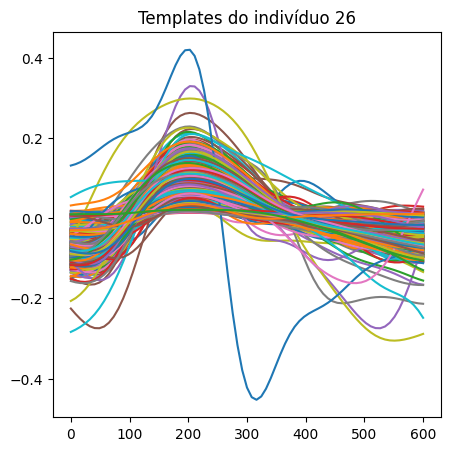

<Figure size 640x480 with 0 Axes>

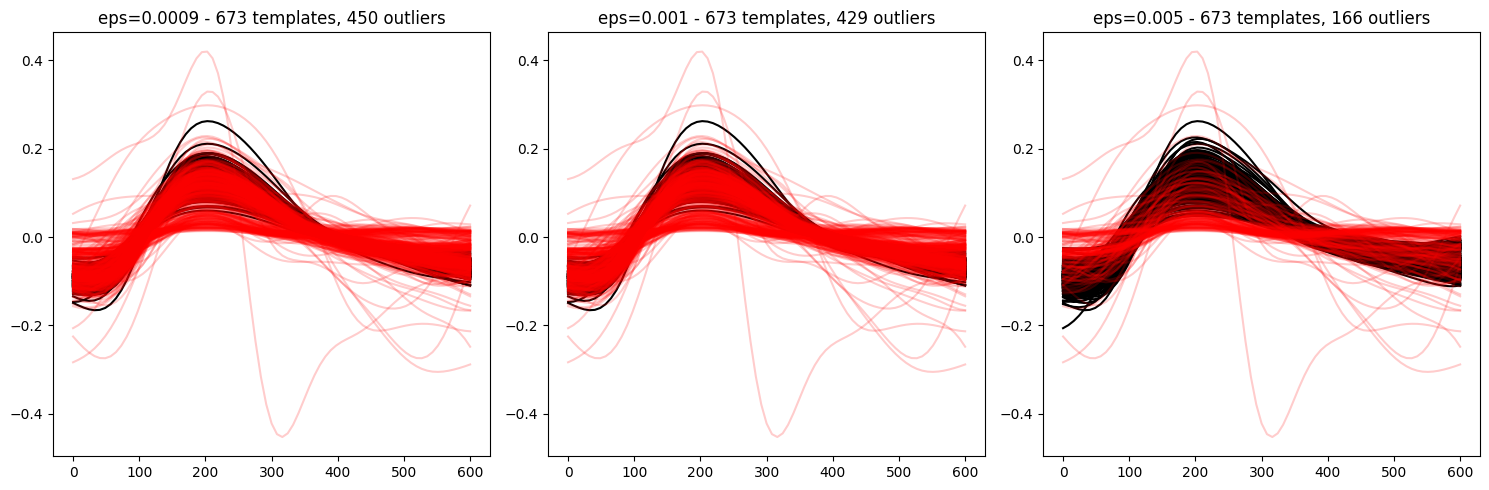

In [157]:
out = bppg.ppg(signal=data[25]['signal'], sampling_rate=data[25]['fs'], show=False)
filtrado = out['filtered']
picos = out['peaks']

offset_left = int(200*data[25]['fs']/1000)
offset_right = int(400*data[25]['fs']/1000)

templates = np.array([filtrado[pico-offset_left:pico+offset_right] for pico in picos[:-1]])

plt.figure(figsize=(5, 5))
plt.title(f"Templates do indivíduo {data[25]['subject']}")
axis = np.linspace(0, 600, 75)
plt.plot(axis, templates.T);
plt.show()

os.makedirs(f"imgs/ind{data[25]['subject']}", exist_ok=True)
plt.savefig(f"imgs/ind{data[25]['subject']}/templates.png")

eps = [0.0009, 0.001, 0.005]

plt.figure(figsize=(15,5))
for i, e in enumerate(eps): 
    result = outliers_dbscan(data=templates, eps=e, min_samples=15, metric='correlation')

    outliers = result['templates'][-1]
    valid = result['templates'][0]
    
    plt.subplot(1,len(eps),i+1)
    plt.title(f"eps={e} - {len(templates)} templates, {len(outliers)} outliers")
    plt.plot(axis, valid.T, label='Valid', color='black');
    plt.plot(axis, outliers.T, label='Outliers', color='red', alpha=0.2);

plt.tight_layout()
plt.show()
    
    # plt.savefig(f"imgs/ind{data[25]['subject']}/outliers_eps{e}.png")


A função abaixo permite detetar e remover outliers do sinal. A deteção de outliers é realizada com recurso à biblioteca BioSpy, que disponibiliza o algoritmo DBSCAN. Assim, esta função recebe apenas o sinal e retorna resultado do algoritmo DBSCAN com os templates válidos e os outliers detectados. Conforme indicado anteriormente, escolha dos parametros epsilon e min_samples foi feita de acordo com a análise dos resultados apresentada no bloco de código anterior.

In [158]:
def outlier_detection(templates, epsilon=0.001, min_samples=15, metric='correlation'):
    try:
        result = outliers_dbscan(data=templates, eps=epsilon, min_samples=min_samples, metric=metric)
        
        outliers = result['templates'][-1]
        valid = result['templates'][0]
        
        return valid, outliers
    
    except Exception as e:
        return None, None

O bloco de código abaixo aplica os processos anteriormente descritos  ao sinal de PPG - filtragem, segmentação e remoção de outliers. Adicionalmente, os dados extraídos de cada um dos blocos são adicionados ao dicionário anteriormente apresentado por cada indivíduo. Assim, o dicionário data passa conter a seguinte estrutura, por indivíduo:	

```python
data = [
            {
            'subject': id do sujeito (indivíduo), 
            'signal': sinal PPG, 
            'fs': frequência de amostragem do sinal, 
            'f_signal': sinais filtrado no processo de filtragem,  
            'peaks': picos identificados no processo de filtragem, 
            'old_templates': templates segmentados no processo de segmentação,
            'templates': templates válidos após remoção de outliers, 
            'outliers': outliers identificados no processo de remoção de outliers, 
            'data_index': indice do indivíduo no dicinario data
            }, 
            ...
        ]
```

Caso não seja possível realizar a deteção de outliers, devido a um número insuficiente de templates, o indivíduo é removido do dicionário data.

In [159]:
SHOW_OUTLIER_DETECTION_DETAILS = False

for individuo in data: 
    signal = individuo['signal']
    fs = individuo['fs']

    out = filtragem(signal, fs, show=False)

    templates = segmentation(out['filtered'], out['peaks'], fs) 

    try:
        valid, outliers = outlier_detection(templates)

        if SHOW_OUTLIER_DETECTION_DETAILS:
            if (individuo['subject'] % 10 == 0):
                plotOutlierDetectionDetails(individuo['subject'], templates, valid, outliers)

        individuo.update({'f_signal': out['filtered'], 
                 'peaks': out['peaks'], 
                 'old_templates': templates,
                 'templates': valid, 
                 'outliers': outliers, 
                 'data_index': data.index(individuo)
                 })

    except Exception as e:
        data.remove(individuo)
        print(f"Erro ao processar os templates do indivíduo {individuo['subject']}: {e}")


O bloco abaixo permite visualizar os detalhes sobre o sinal de um indivíduo, nomeadamente o sinal original, o sinal filtrado, os templates segmentados, bem como os outliers identificados e os templates considerados válidos. O sinal original e sinal filtrado são ainda apresentados com um foco de 10 segundos, podendo ser definida a duração do sinal a visualizar.

Através destas visualizações, conseguimos verificar que o sinal filtrado apresenta menos ruído que o sinal original, e que os templates segmentados correspondem a ciclos do sinal. Conseguimos ainda verificar que os outliers identificados são templates que se encontram fora da distribuição normal do sinal, e que os templates válidos têm menor variabilidade. Ou seja, os templates válidos apresentam um padrão mais regular, enquanto que os outliers apresentam variações entre uma maior gama de valores.

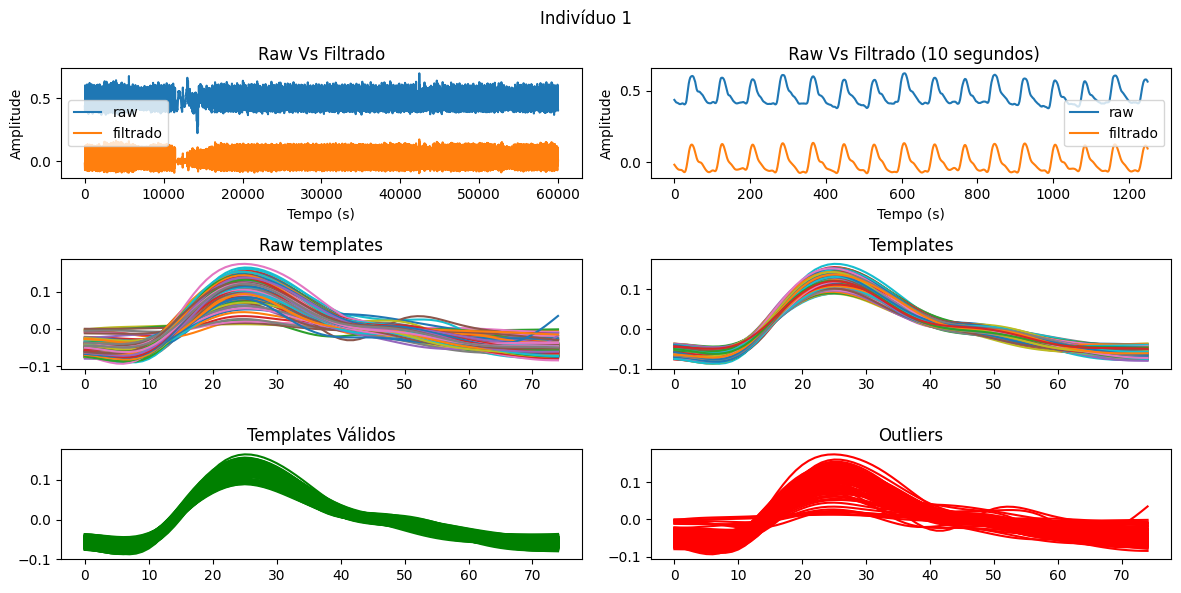

<Figure size 640x480 with 0 Axes>

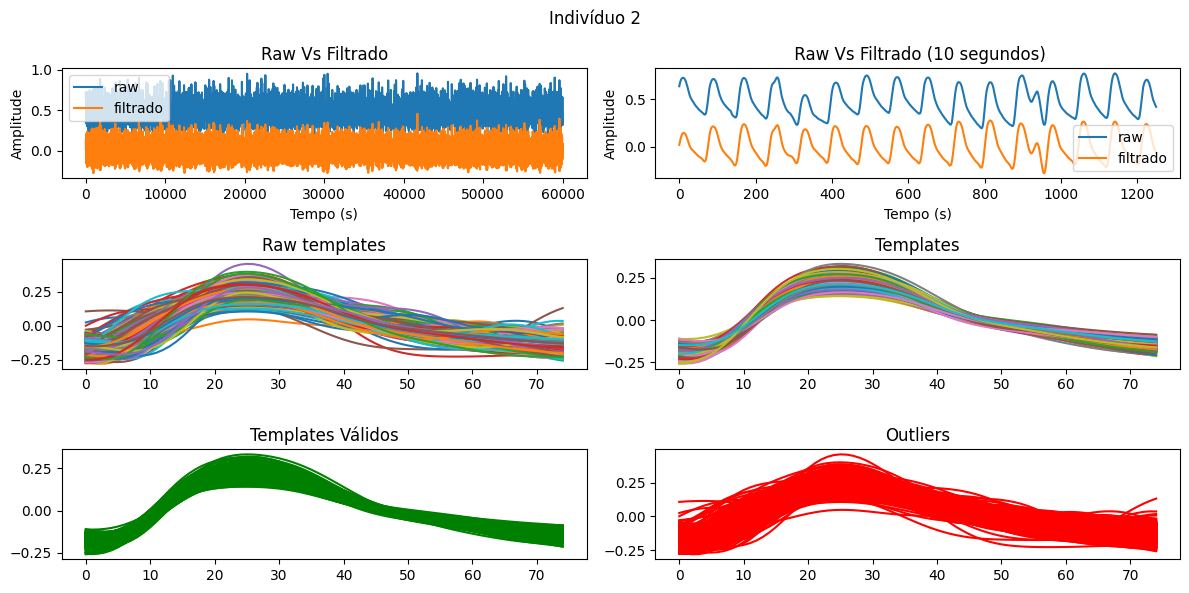

<Figure size 640x480 with 0 Axes>

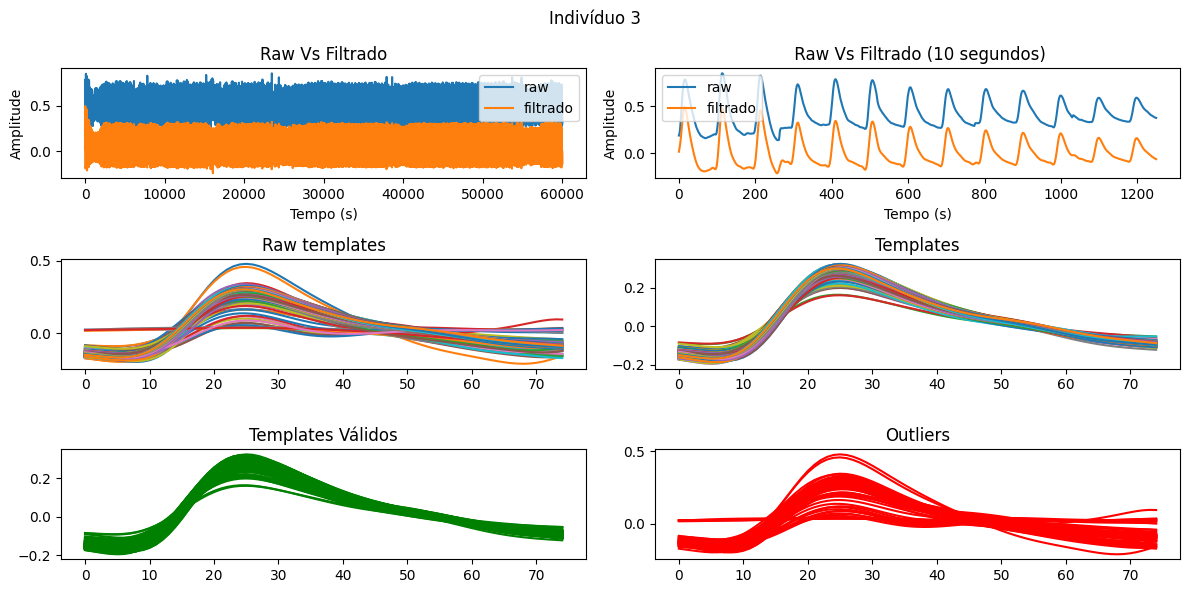

<Figure size 640x480 with 0 Axes>

In [160]:
nIndividuos = 3

for nIndividuo in range(nIndividuos):
    plotSignalDetails(data[nIndividuo])


## Feature Extraction <a name="feature-extraction"></a>

O processo de feature extraction consiste na seleção das caracteristicas de maior interesse. Para isso, os dados podem ser transformados em representações com menor dimensionalidade mantendo as caracteristicas que melhor representam os padrões de cada indivíduo. Durante este processo, são identificadas as caracteristicas mais relevantes do sinal, que permitem identificar padrões característicos de cada indivíduo. 

Através da análise do sinal de PPG, é possível extrair um conjunto de caracteristicas que permitem identificar padrões característicos de cada indivíduo. Entre estas, as mais comuns são: 
- Características do domínio do tempo: características relacionadas com a janela temporal observada do sinal, como a média, a variância, a mediana, o desvio padrão, entre outras.
- Características do domínio da frequência: características relacionadas com o sinal transformado para o domínio da frequência, como a frequência cardíaca, a frequência respiratória, a variabilidade da frequência cardíaca, entre outras.
- Características fiduciais: características específicas de um sinal, como os picos do sinal (sistólico ou diastólico), os intervalos temporais entre os picos, entre outras.

No contexto do projecto, cada indivíduo é caracterizado por um conjunto de templates, que representam vários ciclos do sinal. Estes templates são caracterizados pelos instantes temporais que representam vários ciclos do sinal. Utilizaremos uma rede neuronal capaz de identificar padrões característicos de cada indivíduo, sem a necessidade de extrair características específicas de cada template. Assim, consideramos que cada template representa uma característica única do sinal, que permite identificar padrões característicos de cada indivíduo.

<a name="template-selection"></a>
### Template Selection

O processo de template selection consiste na seleção dos templates mais representativos de cada indivíduo. Para isso, são identificados os clusters de templates que representam os padrões característicos de cada indivíduo. Estes clusters são identificados com recurso a algoritmos de clustering, como o KMeans, que permitem agrupar os templates em clusters de acordo com a sua similaridade. Posteriormente, são identificados os centroids de cada cluster e mantidos os N templates mais representativos de cada cluster. 

A função abaixo permite identificar os clusters de templates de cada indivíduo e, através dos centroides de cada cluster, identificar os N templates mais representativos de cada indivíduo. Para isso, é utilizado o algoritmo KMeans, disponibilizado pela biblioteca BioSpy. A função recebe os templates de cada indivíduo e retorna os N templates mais representativos.

In [161]:
from biosppy.clustering import centroid_templates, consensus_kmeans
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

def template_selection(data, ntemplates=50, k=5): 
    templates = data['templates']
    # print(f"Indivíduo {data['subject']}: {len(templates)} templates")
    clusters = consensus_kmeans(templates, k=k)['clusters']
    selected_templates = centroid_templates(templates, clusters=clusters, ntemplates=ntemplates)['templates']
    # print(f"Indivíduo {data['subject']}: {len(selected_templates)} templates selecionados \n")
    return selected_templates


O bloco de código abaixo permite identificar os templates mais representativos de cada indivíduo. Para isso, é utilizado o algoritmo KMeans, com K = 5. Adicionalmente, caso não seja possível identificar os templates mais representativos o indivíduo é removido do dicionário data, sendo desconsiderado para o processo de enroll. 

São ainda apresentadas as distribuições de templates antes e após o processo de template selection. 

Mínimo de templates: 41 (indivíduo 28)
Máximo de templates: 808 (indivíduo 52)
Limite:  None


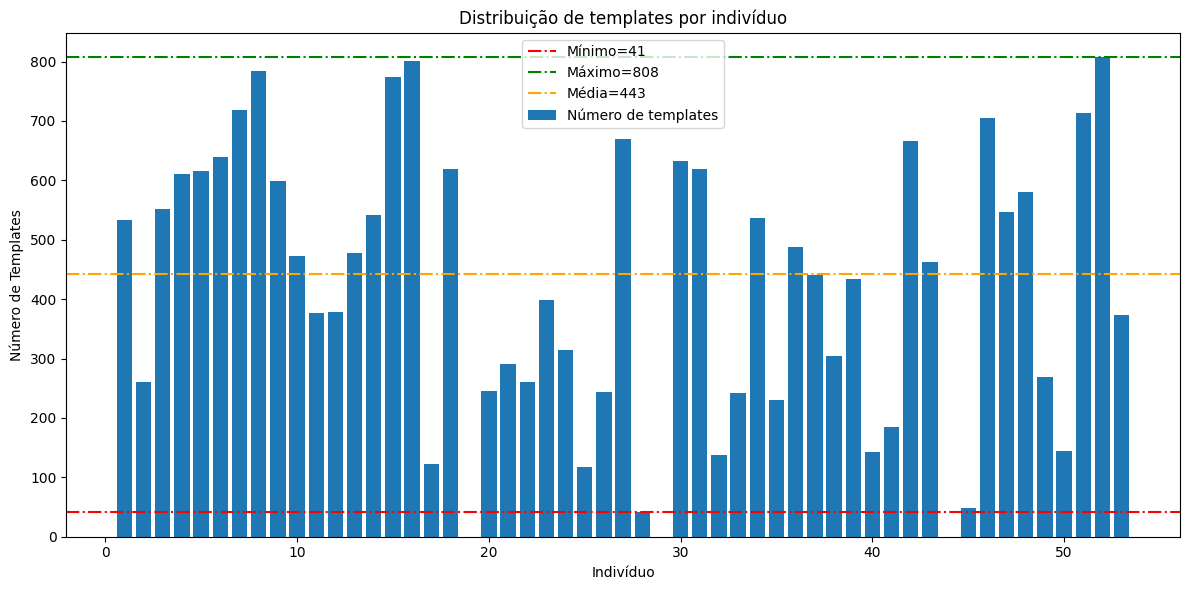

100%|██████████| 50/50 [04:25<00:00,  5.30s/it]

Mínimo de templates: 41 (indivíduo 1)
Máximo de templates: 41 (indivíduo 1)
Limite:  41


<Figure size 640x480 with 0 Axes>

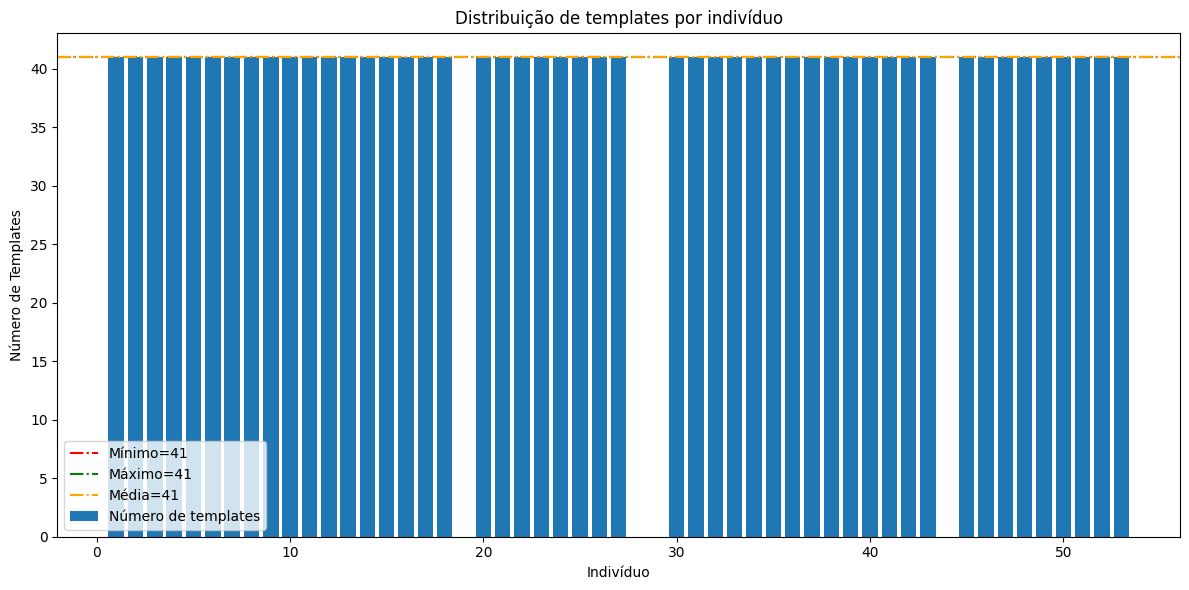

(41, 41, 41)

<Figure size 640x480 with 0 Axes>

In [162]:
data = [individuo for individuo in data if "templates" in individuo.keys() and individuo['templates'] is not None]

min, _, _ = plotTemplatesHistogram(data, key='templates')

# print([individuo['subject'] for individuo in data])

limite = min

not_to_enroll = []
## Normalização dos templates por indivíduo
for individuo in tqdm(data):
    # print(f"Normalizando templates do indivíduo {individuo['subject']}")
    rd.shuffle(individuo['templates'])

    # print(f"Templates do indivíduo {individuo['subject']}: {len(individuo['templates'])}")
    if len(individuo['templates']) > limite:
        
        selected_templates = template_selection(individuo, ntemplates=limite)
        individuo.update({'selected_templates': selected_templates})
    else:
        # print(f"Indivíduo {individuo['subject']} não possui templates suficientes")
        not_to_enroll.append(individuo['subject'])

data = [individuo for individuo in data if individuo['subject'] not in not_to_enroll]

plotTemplatesHistogram(data, key='selected_templates', limite=limite)

<a name="domínio-do-problema"></a>
## Domínio do Problema

O problema proposto consiste na identificação de indivíduos a partir dos seus sinais de PPG. O sinal de PPG é um sinal fisiológico, que contém informação sobre a variação da quantidade de sangue nos vasos sanguíneos, em função do tempo. Este sinal é único para cada indivíduo, uma vez que é influenciado por fatores como a pressão sanguínea, a frequência cardíaca, a idade, entre outros. Assim, a identificação de indivíduos a partir dos seus sinais de PPG é um problema de classificação, que consiste em identificar a que indivíduo pertence um determinado sinal de PPG.

Para resolver este problema, propomos a utilização de um modelo de classificação, que recebe como entrada o sinal de PPG e retorna a identificação do indivíduo a que pertence o sinal. O modelo é treinado com um conjunto de dados de treino, que contém os templates dos sinais de PPG de vários indivíduos, e é testado com um conjunto de dados de teste, que contém templates, não presentes no conjunto de treino, dos sinais de PPG de indivíduos.

Existem duas problemáticas a abordar neste projeto:
- Problema Multiclasse: identificação de vários indivíduos a partir dos seus sinais de PPG.
- Problema Binário: identificação de um indivíduo a partir dos seus sinais de PPG.

Para o problema multiclasse, o modelo proposto é um modelo de classificação multiclasse, que permite identificar vários indivíduos a partir dos seus sinais de PPG. Para isso, o modelo recebe como entrada templates do sinal de PPG de diversos indivíduos e retorna a identificação (classe) do indivíduo a que cada template pertence.

Para o problema binário, o modelo proposto é um modelo de classificação binário, que permite identificar se o sinal pertende a um indivíduo a partir dos seus sinais de PPG. Para isso, o modelo recebe como entrada templates do sinal de PPG de um indivíduo ou mais indivíduos e retorna, para cada template, a identificação (classe) positiva, se o template pertencer ao indívíduo, ou negativa, se o template pertencer a outro indivíduo.

#### Conversão dos templates nos dados de input de treino e teste da rede

In [163]:
X = []
Y = []
for individuo in data: 
    for template in individuo['selected_templates']:
        X.append(template)
        Y.append(int(individuo['subject']))

X = np.array(X)
Y = np.array(Y)

<a name="problema-multiclasse"></a>

## Problema Multiclasse

O problema multiclasse consiste na identificação dos indivíduos em função dos templates dos sinais de PPG. Para isso, é utilizado um modelo de classificação multiclasse, que permite identificar vários indivíduos a partir dos seus sinais de PPG. 

<a name='modelo'></a>
### Modelo

O modelo proposto consiste numa rede neuronal convolucional. As redes neuronais convolucionais são modelos de _deep learning_ que permitem identificar padrões. Estas redes são compostas por várias camadas, que permitem identificar padrões de baixo nível, como bordas e texturas, e padrões de alto nível, como formas e objetos. 

O modelo proposto é composto por três camadas convolucionais, cada camada com filtros de tamanhos diferentes. Isto permite capturar diferentes padrões do sinal. A primeira camada convolucional tem 32 filtros com 5 amostras de dimensão, a segunda é composta 32 filtros com 10 amostras de dimensão e a terceira por 32 filtros com 15 amostras de dimensão. Estes filtros "deslizam" pelo sinal de entrada aplicando a operação matemática de convulção. Cada filtro representa um neurónio, que captura um padrão específico do sinal e é ativado quando esse padrão é identificado. A função de ativação utilizada é a ReLU, que permite a não linearidade do modelo. Por exemplo, se o valor de saída do filtro for negativo, a função ReLU retorna 0, caso contrário, retorna o valor de saída do filtro. Isto faz com que o modelo seja capaz de identificar padrões mais complexos do sinal, porque permite a combinação de diferentes padrões identificados pelos filtros.

As saídas de cada uma das camadas convolutionais são processadas por numa camada de pooling dedicada. Esta camada permite reduzir a dimensionalidade do sinal, mantendo as características mais importantes de cada filtro. A camada de pooling utilizada é a GlobalMaxPooling1D, que retorna o valor máximo de cada filtro em cada camada convolucional. Isto permite reduzier a dimensionalidade do sinal, mantendo os padrões mais significativos de cada uma das convoluções.

Após isto, os resultados de cada uma das camadas de pooling são concatenados e processados por duas camadas densas. Estas camadas estabelecem conexões entre os neurónios das camadas anteriores, permitindo identificar padrões característicos de cada indivíduo em função dos padrões anteriormente identificados nas camadas convolucionais. A primeira camada tem 128 neurónios conectados a cada um dos neurónios das camadas anteriores, ou seja, identifica 128*3*32 padrões característicos de cada indivíduo. A segunda camada tem 53 neurónios (número de indivíduos a classificar) e a função de ativação utilizada é a softmax, retornando a probabilidade de cada indivíduo a que o sinal pertence. O indivíduo com a maior probabilidade é o indivíduo identificado pelo modelo.




In [164]:
from keras.utils import plot_model

N = 32        # Número de filtros
L1, L2, L3 = 5, 10, 15  # Tamanho dos filtros
M = 128       # Número de unidades na camada densa

input_signal = Input(shape=(None, 1), name='raw_ppg_input')

conv1 = Conv1D(filters=N, kernel_size=L1, activation='relu')(input_signal)
conv2 = Conv1D(filters=N, kernel_size=L2, activation='relu')(input_signal)
conv3 = Conv1D(filters=N, kernel_size=L3, activation='relu')(input_signal)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

concatenated_features = Concatenate()([pool1, pool2, pool3])
dense_layer = Dense(3 * N * M, activation='relu')(concatenated_features)

output = Dense(54, activation='softmax')(dense_layer)

model = Model(inputs=input_signal, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

model.save('modelo/multi_ppg.keras')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_ppg_input       │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, None, 32)  │        192 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, None, 32)  │        352 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, None, 32)  │        512 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_15[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_16[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_17[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 12288)     │  1,191,936 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 54)        │    663,606 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,856,598 (7.08 MB)

 Trainable params: 1,856,598 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

##### Criação de datasets de treino e teste

O bloco de código abaixo permite criar os datasets de treino e teste para o problema multiclasse. Para isso, são utilizados os templates dos sinais de PPG de cada indivíduo, que são convertidos em dados de input para a rede neuronal. Os dados de input são normalizados, de forma a garantir que os dados têm a mesma escala. Os dados de input são ainda convertidos em arrays numpy, que são utilizados como input para a rede neuronal.

A divisão dos dados de treino e teste é feita de forma aleatória, garantindo que os dados de treino e teste são representativos da população. Para isso, é utilizado o método train_test_split da biblioteca sklearn, que permite dividir os dados de treino e teste de forma aleatória,mantendo a distribuição das classes nos conjuntos de teste e treino. Os dados de treino correspondem a 80% dos dados, enquanto que os dados de teste correspondem a 20% dos dados.

Através do gráfico apresentado, podemos verificar que os dados de treino e teste têm a mesma distribuição de classes, confirmando que os dados de teste são representativos da população.

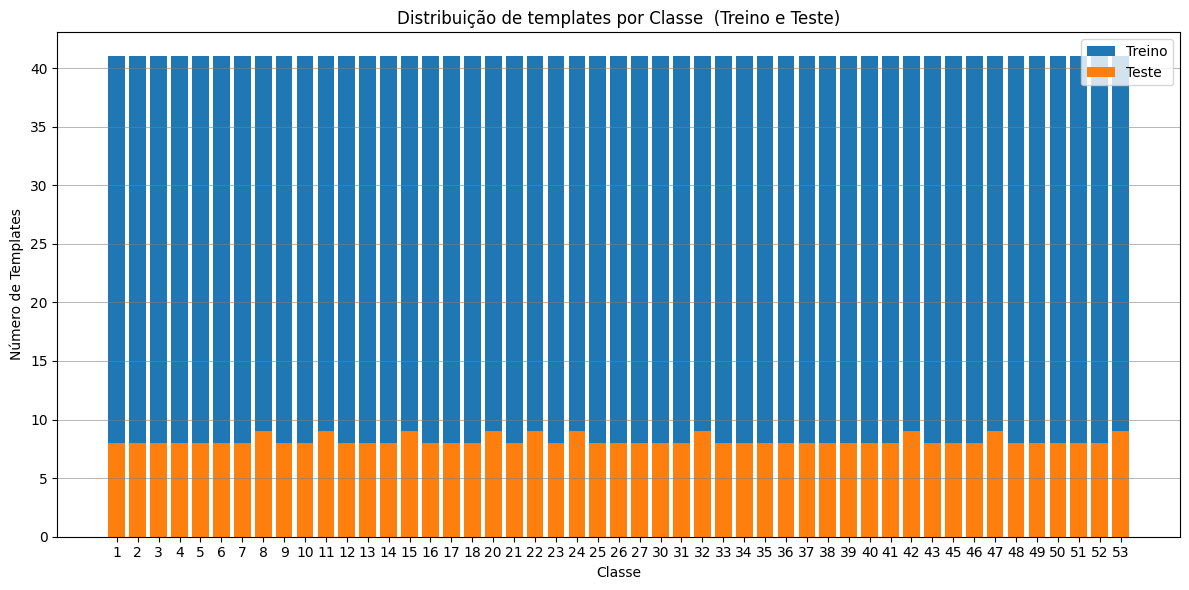

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y, shuffle=True)

plt.figure(figsize=(12, 6))
plt.bar([str(i) for i in np.unique(Y)], [np.sum(Y==i) for i in np.unique(Y)], label='Treino')
plt.bar([str(i) for i in np.unique(y_test)], [np.sum(y_test==i) for i in np.unique(y_test)], label='Teste')
plt.title('Distribuição de templates por Classe  (Treino e Teste)')
plt.xlabel('Classe')
plt.ylabel('Número de Templates')
plt.legend()
plt.grid(axis='y', color='grey', alpha=0.8, linestyle='-', linewidth=0.5)
plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()

<a name="treino"></a>
### Treino

O bloco de código abaixo permite treinar o modelo de classificação multiclasse. Para isso, o conjunto de dados de treino é dividido em batches, que são utilizados para treinar o modelo. Cada batch contém 32 templates, que são utilizados para ajustar os pesos da rede neuronal. O modelo é treinado durante 100 épocas, que correspondem ao número de vezes que o modelo é treinado com o conjunto de dados de treino. O otimizer utilizado é o Adam, que permite ajustar os pesos da rede neuronal de acordo com o erro calculado com a função de perda categorical_crossentropy. Esta função calcula a diferença entre a probabilidade prevista pelo modelo e a probabilidade real. Através do otimizer, o modelo ajusta os pesos de forma a minimizar o erro calculado.

In [166]:
y_train_enc = to_categorical(y_train, num_classes=54)
y_test_enc = to_categorical(y_test, num_classes=54)

X_train_padded = pad_sequences(X_train, padding='post', dtype='float32')

history = model.fit(X_train_padded, y_train_enc, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0189 - loss: 0.3355 - val_accuracy: 0.0186 - val_loss: 0.1182
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0200 - loss: 0.1122 - val_accuracy: 0.0124 - val_loss: 0.1032
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0226 - loss: 0.0999 - val_accuracy: 0.0124 - val_loss: 0.0925
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0266 - loss: 0.0897 - val_accuracy: 0.0621 - val_loss: 0.0843
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0545 - loss: 0.0837 - val_accuracy: 0.0714 - val_loss: 0.0823
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0757 - loss: 0.0819 - val_accuracy: 0.0652 - val_loss: 0.0808
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0704 - loss: 0.0807 - val_accuracy: 0.0963 - val_loss: 0.0796
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0969 - loss: 0.0787 - val_accuracy: 0.

O bloco de código abaixo permite visualizar os resultados do treino do modelo. Internamente, a biblioteca do TensorFlow, divide os dados de treino em dados de treino e validação, de forma a avaliar o desempenho do modelo durante o treino. Assim, são apresentadas as métricas de precisão e perda do modelo durante o treino e validação. 

A precisão do modelo é calculada como a proporção de previsões corretas em relação ao total de previsões. A perda do modelo é calculada como a diferença entre a probabilidade prevista pelo modelo e a probabilidade real. O objetivo do treino é minimizar a perda do modelo, de forma a garantir que o modelo é capaz de identificar os padrões característicos de cada indivíduo. No entanto, esta aprendizagem não pode ser muito rigida, caso contrário o modelo entrará em _overfitting_. O overfitting ocorre quando o modelo é capaz de identificar os padrões do conjunto de dados de treino, mas não é capaz de identificar os padrões de novos dados. Para evitar o overfitting, é importante avaliar o desempenho do modelo durante o treino e validação, de forma a garantir que o modelo é capaz de generalizar.

Podemos verificar que à medida que o modelo é treinado, a precisão do modelo aumenta e a perda do modelo diminui, tanto nos dados de treino como nos dados de validação. Isto indica que o modelo é capaz de identificar os padrões característicos de cada indivíduo, de forma a garantir que o modelo é capaz de identificar os padrões dos novos dados. Verificamos também que o modelo deixa de aprender após aproximadamente 60 épocas, uma vez que a precisão do modelo estabiliza e a perda do modelo não diminui. Isto indica que o modelo é capaz de identificar os padrões característicos de cada indivíduo, de forma a garantir que o modelo é capaz de identificar os padrões dos novos dados.

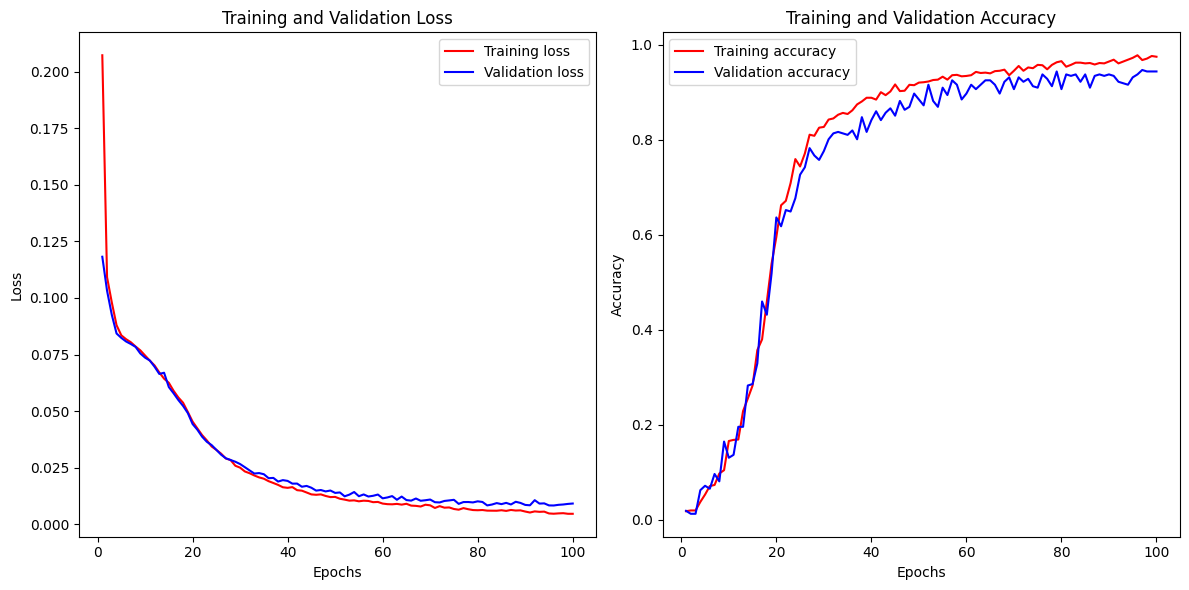

<Figure size 640x480 with 0 Axes>

In [167]:
plotModelHistory(history, type='multi')

#### Guardar Base de Dados

O bloco de código abaixo permite guardar o modelo treinado, bem como os dados de treino. Para isso, é utilizado o método save da biblioteca TensorFlow, que permite guardar o modelo treinado. O modelo é guardado no formato keras, que permite carregar o modelo e utilizar o modelo para identificar os indivíduos a partir dos seus sinais de PPG. Os dados de treino são guardados no formato pickle, que permite guardar os dados de treino e carregar os dados de treino para identificar os indivíduos a partir dos seus sinais de PPG.

In [168]:
import pickle

model.save('modelo/multi_ppg.keras')
with open('database/data.pkl', 'wb') as file:
    pickle.dump(data, file)


<a name="teste"></a>

### Teste

O bloco de código abaixo permite testar o modelo de classificação multiclasse. A divisão dos dados de treino e teste foi realizada anteriormente, garantindo que os dados de teste são representativos da população. Para isso, são utilizados os dados de teste, que contêm os templates dos sinais de PPG de vários indivíduos, que não foram utilizados no treino do modelo. Os dados de teste são convertidos em arrays numpy, que são utilizados como input para o modelo.

In [169]:
X_test_padded = pad_sequences(X_test, padding='post', dtype='float32')

y_pred = model.predict(X_test_padded)

print(y_pred.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(402, 54)



<a name="avaliação"></a>

### Avaliação

O bloco de código abaixo permite avaliar o modelo de classificação multiclasse. Para isso, o bloco de código calcula a matriz de confusão e disponibiliza o relatório de classificação. 

A matriz de confusão permite identificar o número de previsões corretas e incorretas do modelo. A diagonal principal da matriz de confusão corresponde ao número de previsões corretas, enquanto que as outras células correspondem ao número de previsões incorretas. Através da matriz de confusão, é possível identificar que a maioria dos templates de treino foi devidamente classificado, com exceção de alguns templates que foram classificados de forma incorreta, por exemplo 5 templates do indivíduo 32 foram classificados como correspondendo ao indivíduo 2.

O relatório de classificação apresenta as métricas de precisão, recall e f1-score do modelo. A precisão do modelo é calculada como a proporção de previsões corretas em relação ao total de previsões. O recall do modelo é calculado como a proporção de previsões corretas em relação ao total de previsões corretas. O f1-score do modelo é calculado como a média harmónica da precisão e do recall. Estas métricas permitem avaliar o desempenho do modelo, de forma a garantir que o modelo é capaz de identificar os padrões característicos de cada indivíduo.

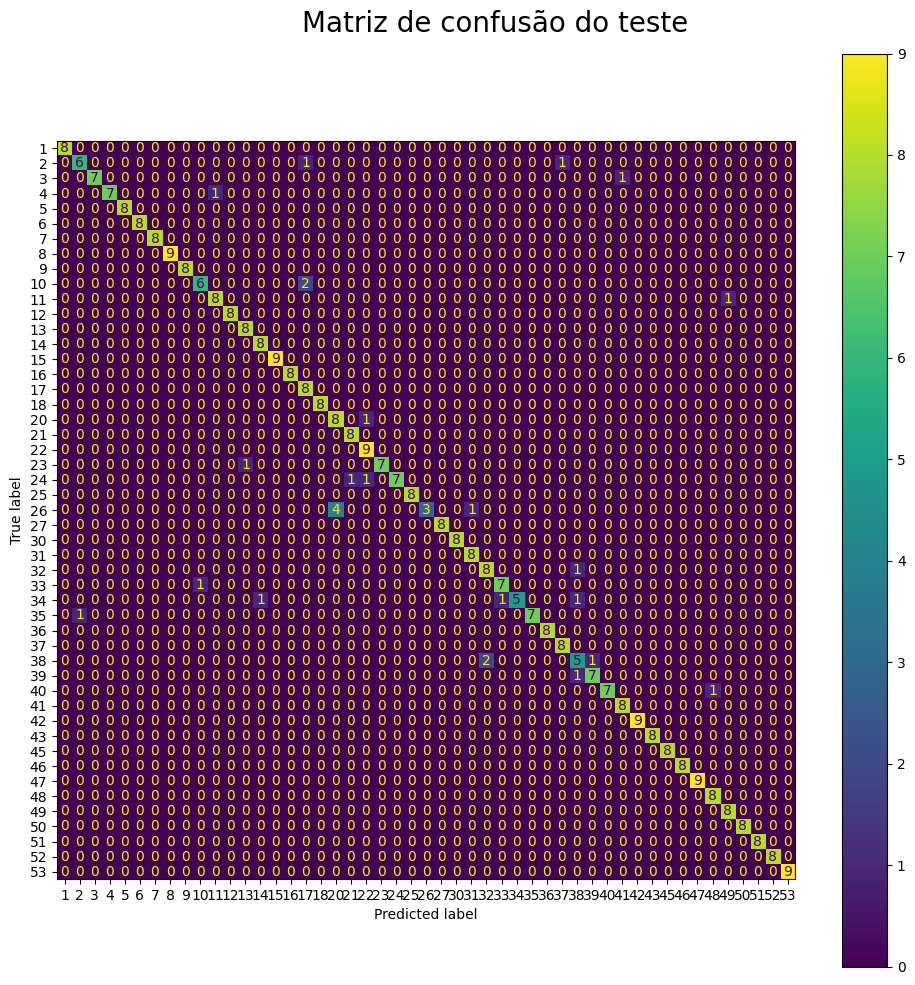

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       0.86      0.75      0.80         8
           3       1.00      0.88      0.93         8
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         8
          10       0.86      0.75      0.80         8
          11       0.89      0.89      0.89         9
          12       1.00      1.00      1.00         8
          13       0.89      1.00      0.94         8
          14       0.89      1.00      0.94         8
          15       1.00      1.00      1.00         9
          16       1.00      1.00      1.00         8
          17       0.73      1.00      0.84         8
          18       1.00    

<Figure size 640x480 with 0 Axes>

In [170]:

# Convert predictions to binary (0 or 1) with threshold 0.5
y_pred_fin = np.argmax(y_pred, axis=1)

plotConfusionMatrix(y_test, y_pred_fin, type='multi')

print(classification_report(y_test, y_pred_fin))


<a name="problema-binário"></a>

## Problema Binário

O problema binário consiste na identificação de um indivíduo a partir dos seus sinais de PPG. Neste problema, o modelo recebe como entrada o sinal de PPG e retorna a classe positiva, se o sinal pertencer ao indivíduo, ou a classe negativa, se o sinal pertencer a outro indivíduo.

<a name='modeloBin'></a>
### Modelo Binário

O modelo proposto é semelhante ao modelo multiclasse, com variações nas últimas camadas densas. A penultima camada densa contém 96 neurões, enquanto que a última camada densa tem apenas um neurónio, que retorna a probabilidade de o template pertencer ao indivíduo. A função de ativação utilizada é a sigmoid, que retorna uma probabilidade entre 0 e 1. Se a probabilidade for superior a 0.5, o template é classificado como pertencendo ao indivíduo, caso contrário, é classificado como não pertencendo ao indivíduo.

Para além disto, também a função de perda é diferente, sendo utilizada a função de perda binary_crossentropy. Esta função calcula a diferença entre a probabilidade prevista pelo modelo e a probabilidade real, para cada template. Através do otimizador, o modelo ajusta os pesos de forma a minimizar o erro calculado.

In [171]:
N = 32
L1, L2, L3 = 5, 10, 15
M = 96

input_signal = Input(shape=(None, 1), name='raw_ppg_input')

conv1 = Conv1D(filters=N, kernel_size=L1, activation='relu')(input_signal)
conv2 = Conv1D(filters=N, kernel_size=L2, activation='relu')(input_signal)
conv3 = Conv1D(filters=N, kernel_size=L3, activation='relu')(input_signal)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

concatenated_features = Concatenate()([pool1, pool2, pool3])

dense_layer = Dense(M, activation='relu')(concatenated_features)

output = Dense(1, activation='sigmoid')(dense_layer)

bin_model = Model(inputs=input_signal, outputs=output)
bin_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bin_model.summary()

bin_model.save('modelo/bin_ppg.keras')

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_ppg_input       │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, None, 32)  │        192 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, None, 32)  │        352 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, None, 32)  │        512 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_18[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_19[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_20[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 96)        │      9,312 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         97 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,465 (40.88 KB)

 Trainable params: 10,465 (40.88 KB)

 Non-trainable params: 0 (0.00 B)

##### Criação de datasets de treino e teste

O bloco de código abaixo permite criar os datasets de treino e teste para o problema binário. Tal como no problema multiclasse, a divisão dos dados de treino e teste é feita de forma aleatória, garantindo que os dados de treino e teste contém o mesmo número de amostras. 

Através do gráfico apresentado, podemos verificar que a divisão dos dados de treino e teste foi realizada de forma a que os dados de treino e teste tenham igual proporção.

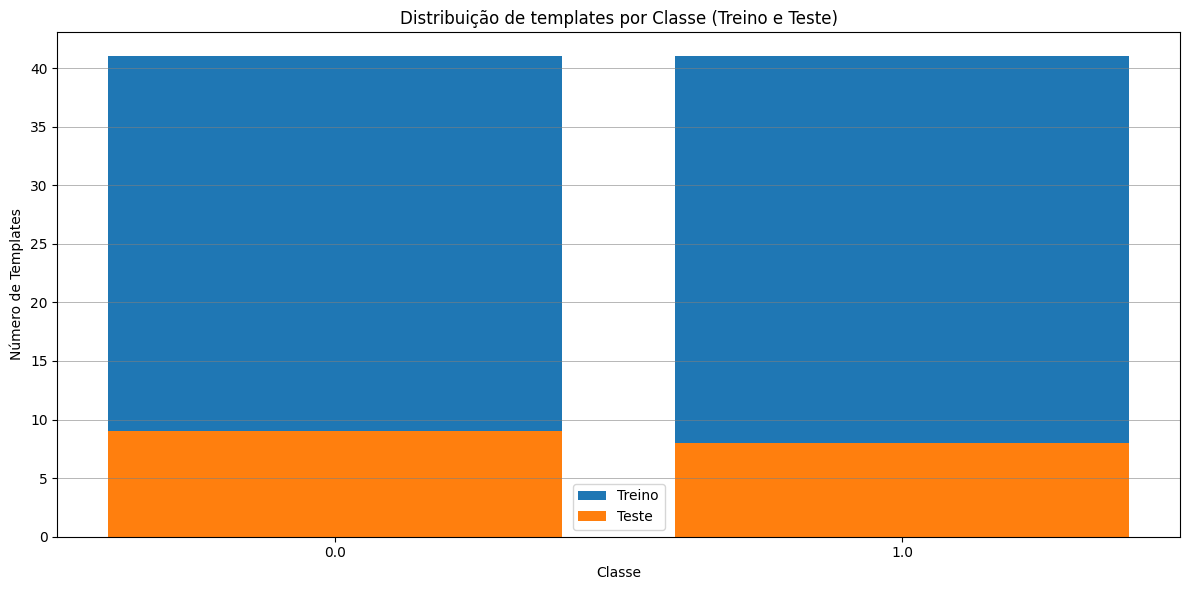

In [172]:
trueClassLabel = 1

Y_bin = (Y == trueClassLabel)*1.

limite = np.sum(Y_bin == 1)

Y_bin_pos = Y_bin[Y_bin == 1]
Y_bin_neg = Y_bin[Y_bin == 0][:limite]

X_pos = X[Y_bin == 1]
X_neg = X[Y_bin == 0][:limite]

X_bin = np.concatenate([X_pos, X_neg])
Y_bin = np.concatenate([Y_bin_pos, Y_bin_neg])



X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, Y_bin, test_size=0.2, random_state=42, stratify=Y_bin, shuffle=True)

plt.figure(figsize=(12, 6))
plt.bar([str(i) for i in np.unique(Y_bin)], [np.sum(Y_bin==i) for i in np.unique(Y_bin)], label='Treino')
plt.bar([str(i) for i in np.unique(y_test_bin)], [np.sum(y_test_bin==i) for i in np.unique(y_test_bin)], label='Teste')
plt.title('Distribuição de templates por Classe (Treino e Teste)')
plt.xlabel('Classe')
plt.ylabel('Número de Templates')
plt.legend()
plt.grid(axis='y', color='grey', alpha=0.8, linestyle='-', linewidth=0.5)
plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()



<a name="treino-1"></a>

### Treino

O bloco de código abaixo permite treinar o modelo de classificação binário. Tal como no treino do modelo multiclasse, o conjunto de dados de treino é dividido em batches, onde cada batch contém 32 templates, que são utilizados para ajustar os pesos da rede neuronal. Este modelo é treinado durante 40 épocas. E a função de perda utilizada é a binary_crossentropy, que calcula a diferença entre a probabilidade prevista pelo modelo e a probabilidade real. O otimizador utilizado é o Adam, que permite ajustar os pesos da rede neuronal de acordo com o erro calculado.

In [173]:
X_train_bin_padded = pad_sequences(X_train_bin, padding='post', dtype='float32')

history_bin = bin_model.fit(X_train_bin_padded, np.array(y_train_bin), epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.5208 - loss: 0.6911 - val_accuracy: 0.4615 - val_loss: 0.6861
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4688 - loss: 0.6836 - val_accuracy: 0.4615 - val_loss: 0.6811
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5312 - loss: 0.6737 - val_accuracy: 0.4615 - val_loss: 0.6772
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4792 - loss: 0.6722 - val_accuracy: 0.4615 - val_loss: 0.6729
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4896 - loss: 0.6657 - val_accuracy: 0.4615 - val_loss: 0.6685
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4896 - loss: 0.6605 - val_accuracy: 0.4615 - val_loss: 0.6634
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6517 - val_accuracy: 0.4615 - val_loss: 0.6585
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4792 - loss: 0.6509 - val_accuracy: 0.4615 - val_loss: 0.6536


O bloco de código abaixo permite visualizar os resultados do treino do modelo binário. 

Podemos verificar que o modelo deixa de aprender após aproximadamente 20 épocas, uma vez que a precisão do modelo estabiliza e a perda do modelo não diminui. No entanto, conseguimos verificar também que o modelo identifica claramente os templates que pertencem ao indivíduo, com uma precisão de 100% e uma perda de 0. Isto significa que o modelo é capaz de segregação dos templates do indivíduo dos templates dos outros indivíduos. 

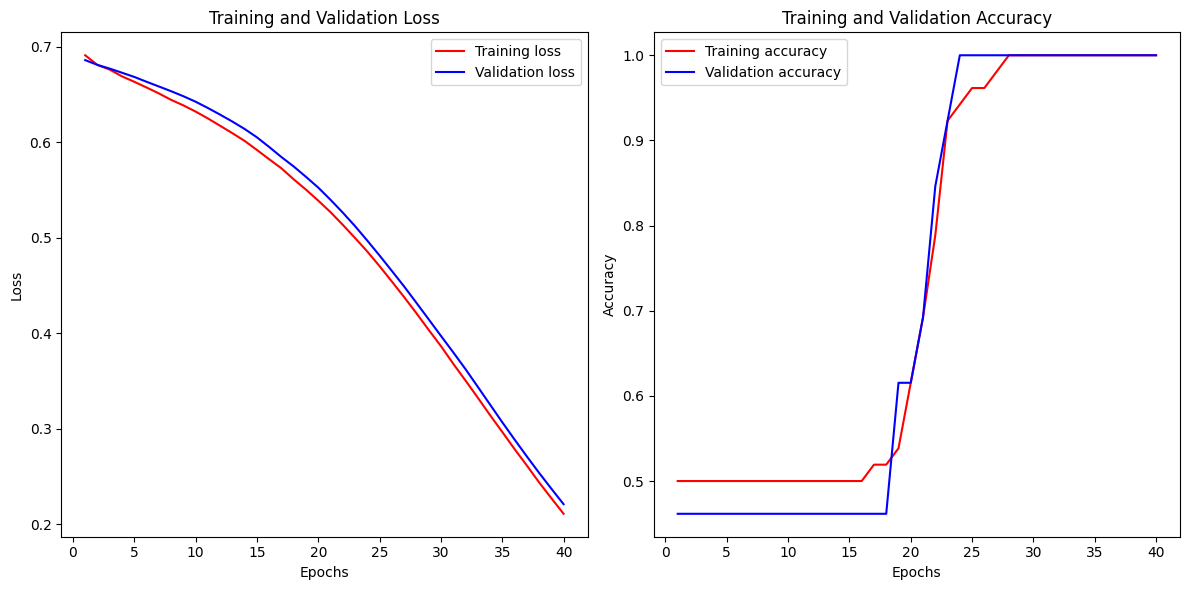

<Figure size 640x480 with 0 Axes>

In [174]:
import matplotlib.pyplot as plt

plotModelHistory(history_bin, type='bin')



<a name="teste-1"></a>

### Teste

O bloco de código abaixo permite testar o modelo de classificação binário. Para isso, são utilizados os dados de teste, que contêm os templates dos sinais de PPG de vários indivíduos, que não foram utilizados no treino do modelo. Os dados de teste são convertidos em arrays numpy, que são utilizados como input para o modelo.

In [175]:
X_test_bin_padded = pad_sequences(X_test_bin, padding='post', dtype='float32')

y_bin_pred = bin_model.predict(X_test_bin_padded)

print(y_bin_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(17, 1)



<a name="avaliação-1"></a>
### Avaliação

O bloco de código abaixo permite avaliar o modelo de classificação binário. Para isso, podemos usar a curva ROC juntamente com a área sob a curva ROC, e a matriz de confusão. 

A curva ROC permite avaliar a capacidade do modelo de identificar os verdadeiros positivos e os falsos positivos. A área sob a curva ROC é uma métrica de avaliação do modelo, que varia entre 0 e 1. Quanto maior for a área sob a curva ROC, melhor é o desempenho do modelo. Verificamos que a área sob a curva ROC é de 1, o que indica que o modelo é capaz de identificar os verdadeiros positivos e os falsos positivos de forma eficiente (o classificador ideal). 

Para além disso, podemos verificar, pela matriz de confusão, que o modelo é capaz de identificar corretamente os templates do indivíduo, com uma precisão de 100%. Isto significa que o modelo é capaz de identificar os padrões característicos do indivíduo, de forma a garantir que o modelo é capaz de identificar os templates do indivíduo.

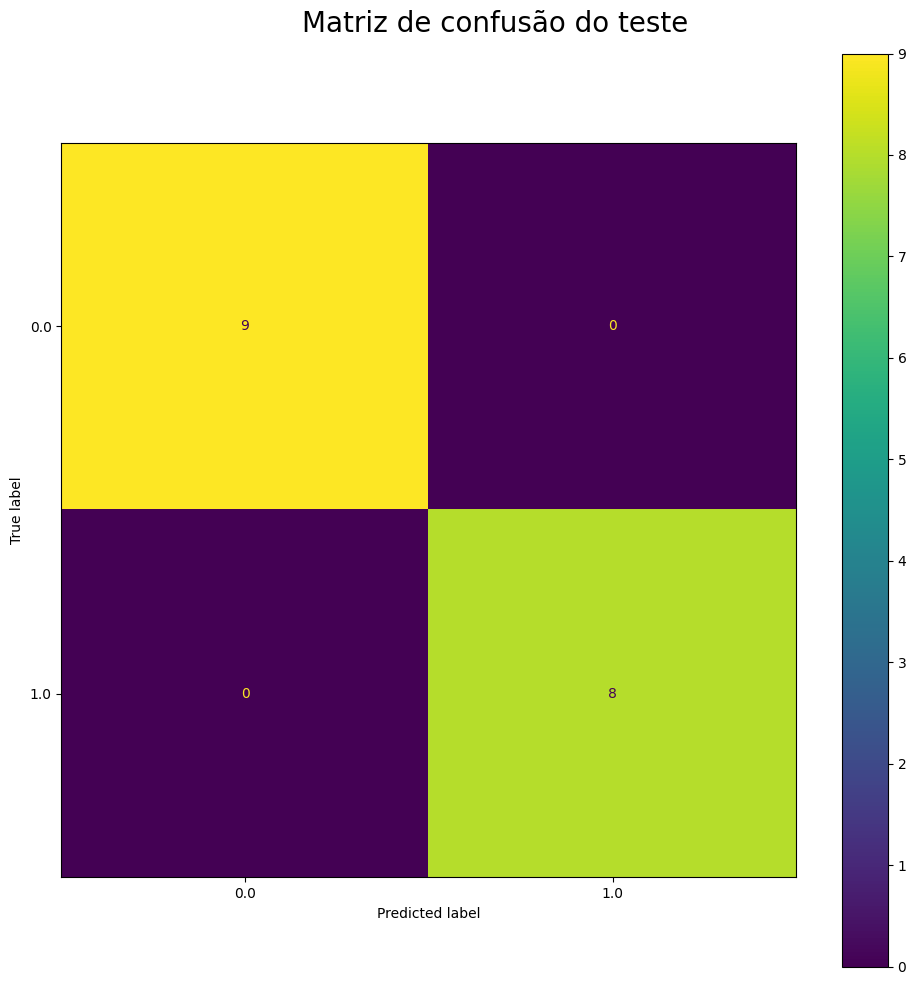

<Figure size 640x480 with 0 Axes>

In [176]:
y_bin_pred_fin = (y_bin_pred > 0.5)*1.

plotConfusionMatrix(y_test_bin, y_bin_pred_fin, type='bin')

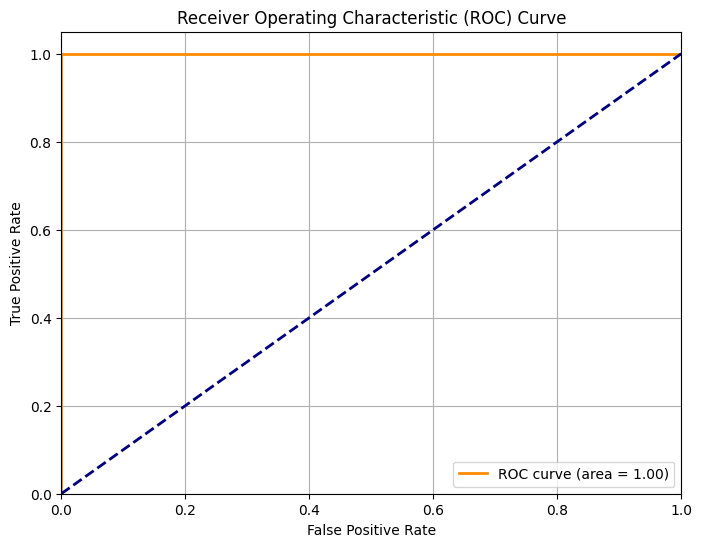

<Figure size 640x480 with 0 Axes>

In [177]:
plotROCCurves(y_test_bin, y_bin_pred)

____________

## Conclusão

O sinal de PPG é um sinal fisiológico, que contém informação sobre a variação da quantidade de sangue nos vasos sanguíneos, em função do tempo. Este sinal é único para cada indivíduo, uma vez que é influenciado por fatores como a pressão sanguínea, a frequência cardíaca, a idade, entre outros. Assim, a identificação de indivíduos a partir dos seus sinais de PPG é um problema de classificação, que consiste em identificar a que indivíduo pertence um determinado sinal de PPG.

A análise dos sinais de PPG é uma área de investigação em crescimento, que tem vindo a ser explorada em várias aplicações, como a identificação de indivíduos, a monitorização da saúde, a deteção de doenças, entre outras. A utilização de sinais de PPG para identificar indivíduos é uma área de investigação promissora, que tem vindo a ser explorada em vários estudos.

Neste projeto propôs-se a identificação de indivíduos a partir dos seus sinais de PPG. Para isso, foi proposto a utilização de um modelo de classificação multiclasse e um modelo de classificação binário baseado em redes neuronais convolucionais. O modelo de classificação multiclasse que permite identificar os indivíduos através dos seus sinais de PPG, enquanto que o modelo de classificação binário permite identificar se um determinado sinal de PPG pertence a um indivíduo em específico. 

Os resultados obtidos mostram que os modelos propostos são capazes de identificar corretamente os indivíduos a partir dos seus sinais de PPG. O modelo de classificação multiclasse obteve uma precisão de 95%, enquanto que o modelo de classificação binário obteve uma precisão de 100%. Isto significa que os modelos são capazes de identificar os padrões característicos de cada indivíduo, de forma a garantir que o modelo é capaz de identificar os padrões dos novos dados.
_____________

## Referências

- [BIDMC PPG and Respiration Dataset](https://physionet.org/content/bidmc/1.0.0/)
- [BioSpy](https://biosppy.readthedocs.io/en/stable/biosppy.signals.html)
- 